In [1]:
import pandas as pd
from torch.utils import data
import numpy as np
import torch
import os
from PIL import Image
import random
import cv2

from models.network_b0 import *

import albumentations as A
import matplotlib.pyplot as plt

HEIGHT=288
WIDTH=512
mag = 1
sigma = 2.5


In [2]:

def genHeatMap(w, h, cx, cy, r, mag):
    if cx < 0 or cy < 0:
      return np.zeros((h, w))
    x, y = np.meshgrid(np.linspace(1, w, w), np.linspace(1, h, h))
    heatmap = ((y - (cy + 1))**2) + ((x - (cx + 1))**2)
    heatmap[heatmap <= r**2] = 1
    heatmap[heatmap > r**2] = 0
    return heatmap*mag


def getData(mode):
    if mode == 'train':
        img = pd.read_csv('tracknet_train_list_x_3.csv')
        label = pd.read_csv('tracknet_train_list_y_3.csv')
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('tracknet_test_list_x_3.csv')
        label = pd.read_csv('tracknet_test_list_y_3.csv')
        return np.squeeze(img.values), np.squeeze(label.values)


class TrackNetLoader(data.Dataset):
    def __init__(self, root, mode):
        self.root = root
        self.img_name, self.label_name = getData(mode)
        self.mode = mode
        img = Image.open(self.img_name[0][0]).convert('LA')
        w, h = img.size
        self.ratio = h / HEIGHT
        print("> Found %d data..." % (len(self.img_name)))

    def __len__(self):
        """'return the size of dataset"""
        return len(self.img_name)

    def __getitem__(self, index):
        img_path = self.img_name[index]
        label_path = self.label_name[index]
        img_all = []
        label_all = []
        for i in range(3):
            x = Image.open(img_path[i]).convert('RGB')
            x = x.resize((WIDTH, HEIGHT))
            
            x = np.asarray(x).transpose(2, 0, 1) / 255.0
            #x = x.resize((WIDTH, HEIGHT, 3))

            img_all.append(x[0])
            img_all.append(x[1])
            img_all.append(x[2])

            y = Image.open(label_path[i])
            y = np.asarray(y) / 255.0
            label_all.append(y)

        img_all = np.asarray(img_all)
        label_all = np.asarray(label_all)
        '''
        if self.mode == 'train':
          if random.random() < 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
        '''
        return img_all, label_all

In [38]:
train_loader = TrackNetLoader('','train')

> Found 3273 data...


In [39]:
img_all, label_all = train_loader[50]

In [40]:
print(np.array(img_all).shape)
print(np.array(label_all).shape)

(9, 288, 512)
(3, 288, 512)


In [41]:
pil_image=Image.fromarray(np.array(label_all[2]))
pil_image.show()

In [42]:
def outcome(y_pred, y_true, tol):
    n = y_pred.shape[0]
    i = 0
    TP = TN = FP1 = FP2 = FN = 0
    while i < n:
        for j in range(1):
            if torch.max(y_pred[i][j]) == 0 and torch.max(y_true[i][j]) == 0:
                TN += 1
            elif torch.max(y_pred[i][j]) > 0 and torch.max(y_true[i][j]) == 0:
                FP2 += 1
            elif torch.max(y_pred[i][j]) == 0 and torch.max(y_true[i][j]) > 0:
                FN += 1
            elif torch.max(y_pred[i][j]) > 0 and torch.max(y_true[i][j]) > 0:
                h_pred = (y_pred[i][j] * 255).cpu().numpy()
                h_true = (y_true[i][j] * 255).cpu().numpy()
                h_pred = h_pred.astype('uint8')
                h_true = h_true.astype('uint8')


                #debug_img = cv2.hconcat([h_pred, h_true])

                #h_pred
                (cnts, _) = cv2.findContours(h_pred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                rects = [cv2.boundingRect(ctr) for ctr in cnts]
                max_area_idx = 0
                max_area = rects[max_area_idx][2] * rects[max_area_idx][3]
                for j in range(len(rects)):
                    area = rects[j][2] * rects[j][3]
                    if area > max_area:
                        max_area_idx = j
                        max_area = area
                target = rects[max_area_idx]
                (cx_pred, cy_pred) = (int(target[0] + target[2] / 2), int(target[1] + target[3] / 2))

                #h_true
                (cnts, _) = cv2.findContours(h_true.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                rects = [cv2.boundingRect(ctr) for ctr in cnts]
                max_area_idx = 0
                max_area = rects[max_area_idx][2] * rects[max_area_idx][3]
                for j in range(len(rects)):
                    area = rects[j][2] * rects[j][3]
                    if area > max_area:
                        max_area_idx = j
                        max_area = area
                target = rects[max_area_idx]
                (cx_true, cy_true) = (int(target[0] + target[2] / 2), int(target[1] + target[3] / 2))
                dist = math.sqrt(pow(cx_pred-cx_true, 2)+pow(cy_pred-cy_true, 2))
                if dist > tol:
                    FP1 += 1
                else:
                    TP += 1
        i += 1
    return (TP, TN, FP1, FP2, FN)

def evaluation(TP, TN, FP1, FP2, FN):
    try:
        accuracy = (TP + TN) / (TP + TN + FP1 + FP2 + FN)
    except:
        accuracy = 0
    try:
        precision = TP / (TP + FP1 + FP2)
    except:
        precision = 0
    try:
        recall = TP / (TP + FN)
    except:
        recall = 0
    return (accuracy, precision, recall)

def WBCE(y_pred, y_true):
    eps = 1e-7
    loss = (-1)*(torch.square(1 - y_pred) * y_true * torch.log(torch.clamp(y_pred, eps, 1)) + torch.square(y_pred) * (1 - y_true) * torch.log(torch.clamp(1 - y_pred, eps, 1)))
    return torch.mean(loss)

def train(epoch):
    model.train()
    train_loss = 0
    TP = TN = FP1 = FP2 = FN = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.type(torch.FloatTensor).to(device)
        label = label.type(torch.FloatTensor).to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = WBCE(y_pred, label)

        #print('Train Epoch" {} [{}/{} ({:.0f}%)] \t Loss : {:.8f}'.format(epoch, (batch_idx+1) * len(data), len(train_loader.dataset),100.0 * (batch_idx+1) / len(train_loader), float(loss.data.cpu().numpy())))

        print('Train Epoch" {} [{}/{} ({:.0f}%)]'.format(epoch, (batch_idx+1) * len(data), len(train_loader.dataset),100.0 * (batch_idx+1) / len(train_loader))+'\tLoss :',format(float(loss.data.cpu().numpy()),'.1E'))


        #print('Train Epoch" {} [{}/{} ({:.0f}%)]\t'.format(epoch, (batch_idx+1) * len(data), len(train_loader.dataset),100.0 * (batch_idx+1) / len(train_loader)),"Loss :",float(loss.data.cpu().numpy())  )

        train_loss += loss.data
        #loss.backward()
        #optimizer.step()
        if(epoch % 1 == 0):
            y_pred = y_pred > 0.5
            (tp, tn, fp1, fp2, fn) = outcome(y_pred, label, tol)
            TP += tp
            TN += tn
            FP1 += fp1
            FP2 += fp2
            FN += fn

            #show(train_loss, epoch)
    train_loss /= len(train_loader)
    if(epoch % 1 == 0):
        display(TP, TN, FP1, FP2, FN)
        savefilename = save_weight + '_{}.tar'.format(epoch)
        torch.save({'epoch':epoch,'state_dict':model.state_dict(),},savefilename)
    return train_loss


def display(TP, TN, FP1, FP2, FN):
    print('======================Evaluate=======================')
    print("Number of true positive:", TP)
    print("Number of true negative:", TN)
    print("Number of false positive FP1:", FP1)
    print("Number of false positive FP2:", FP2)
    print("Number of false negative:", FN)
    (accuracy, precision, recall) = evaluation(TP, TN, FP1, FP2, FN)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print('=====================================================')



def show(train_loss):
    epoch_num = np.arange(1, epochs + 1, 1)
    plt.cla()
    plt.grid(True)
    plt.figure(figsize=(10, 8))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title('Loss of TrackNet3')
    train_loss_plt = plt.plot(epoch_num, train_loss, marker=".")
    plt.savefig('Loss_of_{}.jpg'.format(epoch))
    print('train loss : ' , train_loss)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU Use : ',torch.cuda.is_available())
#train_data = TrackNetLoader('' , 'train')
#train_loader = DataLoader(dataset = train_data, batch_size=batchsize, shuffle=True)
model = EfficientNet(1.2,1.4)
model.to(device)

GPU Use :  True


EfficientNet(
  (init): Sequential(
    (0): SamePadConv2d(9, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (stem): Sequential(
    (0): SamePadConv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (MBBlock_1): MBBlock(
    (layers): Sequential(
      (0): MBConv(
        (expand_conv): Identity()
        (depth_wise_conv): Sequential(
          (0): SamePadConv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), groups=40, bias=False)
          (1): BatchNorm2d(40, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Swish()
        )
        (se): SEModule(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (2): Swish()
        

In [7]:
# set train parameter

batchsize = 1
epochs = 30
lr = 1.
tol = 4
optimizer = 'Adadelta'
momentum = 0.9
weight_decay = 5e-4
seed = 1
load_weight = False
save_weight = 'custom'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU Use : ',torch.cuda.is_available())
#train_data = TrackNetLoader('' , 'train')
#train_loader = DataLoader(dataset = train_data, batch_size=batchsize, shuffle=True)
model = EfficientNet(1,1)
model.to(device)




GPU Use :  True


EfficientNet(
  (init): Sequential(
    (0): SamePadConv2d(9, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (stem): Sequential(
    (0): SamePadConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (MBBlock_1): MBBlock(
    (layers): Sequential(
      (0): MBConv(
        (expand_conv): Identity()
        (depth_wise_conv): Sequential(
          (0): SamePadConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Swish()
        )
        (se): SEModule(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): Swish()
         

In [ ]:
if optimizer == 'Adadelta':
    optimizer = torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06, weight_decay=0)
    #optimizer = torch.optim.Adam(model.parameters(), lr = args.lr, weight_decay = args.weight_decay)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay, momentum = momentum)

if(load_weight):
    print('======================Retrain=======================')
    checkpoint = torch.load(load_weight)
    model.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']

train_loss = []

for epoch in range(1, epochs + 1):
    loss = train(epoch)
    train_loss.append(loss)

show(train_loss)

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()

del train_data
del train_loader
del model

NameError: name 'train_data' is not defined

In [44]:
1 % 1

0

In [17]:
a = np.random.rand(4,4,3)
b = np.random.rand(4,4,3)
c = np.random.rand(4,4,3)

In [18]:
unit = np.stack([a,b,c], axis=2)

In [19]:
unit.shape

(4, 4, 3, 3)

In [33]:
a[a<0.1]

array([0.08035313, 0.06188116, 0.00235755, 0.06389794])

In [36]:
a[np.where(a<0.1)]

array([0.08035313, 0.06188116, 0.00235755, 0.06389794])

In [2]:
import os
import argparse
from glob import glob

#parser = argparse.ArgumentParser(description = 'video_trans_img')
#parser.add_argument('--dataset', type = str, default='tennis_FOV_dataset', help = 'input your custom dataset folder path')
#args = parser.parse_args()

path = "./" + "tennis_FOV_dataset"
file_list = os.listdir(path)

In [4]:
p = os.path.join("tennis_FOV_dataset", game_list[0], 'frame', '1_00_02', '1.png')

NameError: name 'game_list' is not defined

In [5]:
p = os.path.join(path, file_list[0], 'rally_video', '*mp4')

In [6]:
os.listdir(path)

['match_4', 'match_6', 'match_5', 'match_3', 'match_1', 'match_2']

In [19]:
videoName = glob(p)

In [32]:
rallyName = videoName[0][len(os.path.join(file_list[0], 'rally_video'))+1:-4]

In [33]:
rallyName

'/match_4/rally_video/6'

In [31]:
len(os.path.join(file_list[0], 'rally_video'))+1

20

In [44]:
videoName[0][:-4]

'./tennis_FOV_dataset/match_4/rally_video/6'

In [45]:
output = videoName[0][:-4].split('/')
output

['.', 'tennis_FOV_dataset', 'match_4', 'rally_video', '6']

In [50]:
os.path.join(output[0] , output[1],output[2],'frame'  , output[4])

'./tennis_FOV_dataset/match_4/frame/6'

In [8]:
data = pd.read_csv("./tennis_FOV_dataset/match_1/ball_trajectory/1_ball.csv")
no = data['Frame'].values
v = data['Visibility'].values
x = data['X'].values
y = data['Y'].values
r = data['R'].values

In [10]:
r

array([0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [11]:
a = (1280, 720)

In [13]:
a[1]/288

2.5

In [14]:
a[0]/512

2.5

In [18]:
(3/2.5) ** 2

1.44

In [20]:
np.round(np.sqrt(9/2.5))

2.0

In [17]:
import time

def tran_input_img(img_list):

    trans_img = []
    t0 = time.time()

    for i in range(len(img_list)):

        img = img_list[i]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = cv2.resize(img,(WIDTH, HEIGHT))
        img = np.asarray(img).transpose(2, 0, 1) / 255.0

        trans_img.append(img[0])
        trans_img.append(img[1])
        trans_img.append(img[2])

    trans_img = np.asarray(trans_img)
    t1 = time.time()
    
    print(t1 -t0)
    return trans_img.reshape(1,trans_img.shape[0],trans_img.shape[1],trans_img.shape[2])

In [18]:
a = np.zeros([288,512,3],dtype = 'uint8')
b = np.zeros([288,512,3],dtype = 'uint8')
c = np.zeros([288,512,3],dtype = 'uint8')
img_list = [a,b,c]

In [20]:
z = tran_input_img(img_list)

0.009733438491821289


In [21]:
import matplotlib.pyplot as plt


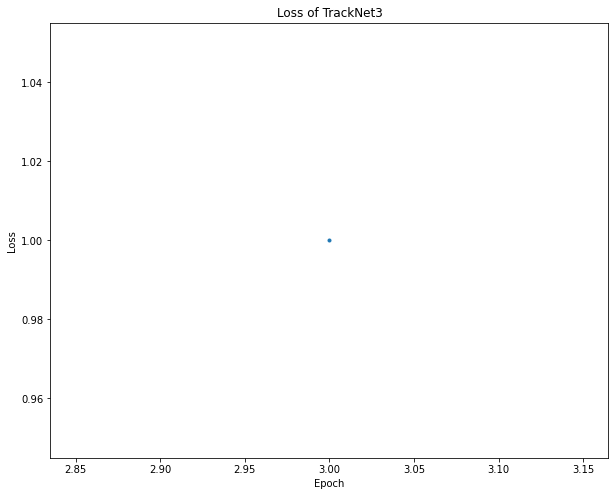

In [28]:
plt.figure(figsize=(10, 8))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss of TrackNet3')
train_loss_plt = plt.plot(3, 1, marker=".")

plt.savefig('Loss_of_{}.jpg'.format(3))


In [5]:
a = np.array([[1,2,3],[4,5,6]])

a[:,-1]

array([3, 6])

In [7]:
prec = 0.712
recall = 0.575

print(2 * (prec * recall)/ (prec + recall) )

0.6362082362082362


In [11]:
np.empty(1)

array([5.e-324])

In [15]:
np.size(np.empty(1))

1

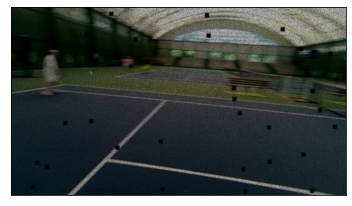

In [41]:
image = plt.imread('tennis_FOV_dataset/match_1/frame/1/75.png')
heatmap_image = plt.imread('tennis_FOV_dataset/match_1/heatmap/1/75.png')


transform = A.Compose([
                    A.HorizontalFlip(p=1),
                    A.Cutout(num_holes=30, max_h_size = 16, max_w_size = 16, fill_value=0, p=1),
                    #A.RandomContrast(limit=0.8, p=0.5),
                    A.RandomGamma(gamma_limit=(80, 120), p=1),
                    A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit = 0.2, p=1),
                    A.Blur(blur_limit=(5, 5), p =1),
                    A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, p=1)
                ])

transformed = transform(image=image, mask = heatmap_image)
transformed_image = transformed['image']
transformed_mask_image = transformed['mask']


plt.imshow(transformed_image)

plt.xticks([]); plt.yticks([])
plt.show()

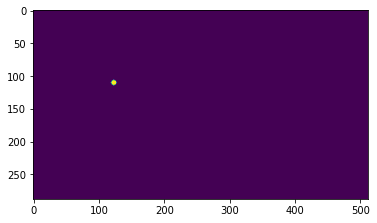

In [42]:

plt.imshow(transformed_mask_image)

In [51]:
x_0 = np.zeros([288,512,3]).transpose(2,0,1)
x_1 = np.zeros([288,512,3]).transpose(2,0,1)
x_2 = np.zeros([288,512,3]).transpose(2,0,1)
img_all = []
for i in [x_0, x_1, x_2]:
        img_all.append(i[0])
        img_all.append(i[1])
        img_all.append(i[2])

In [52]:
np.array(img_all).shape

(9, 288, 512)

In [1]:
import os
import sys
import json
import torch
import argparse
from torch.utils.data import TensorDataset, DataLoader
import torchvision.models as models
import numpy as np
from dataloader_custom import TrackNetLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import cv2
import math
from PIL import Image
import time
from network import *

In [2]:
def WBCE(y_pred, y_true):
    eps = 1e-7
    loss = (-1)*(torch.square(1 - y_pred) * y_true * torch.log(torch.clamp(y_pred, eps, 1)) +
            torch.square(y_pred) * (1 - y_true) * torch.log(torch.clamp(1 - y_pred, eps, 1)))
    return torch.mean(loss)


In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU Use : ',torch.cuda.is_available())

model = efficientnet_b3().to(device)
optimizer = torch.optim.Adadelta(
    model.parameters(), lr=0.1, rho=0.9, eps=1e-06, weight_decay=0)

GPU Use :  True


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.80 GiB total capacity; 3.43 GiB already allocated; 52.62 MiB free; 3.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [51]:
checkpoint = torch.load('weights/custom_5.tar')
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']

data = torch.randn(1, 9, 288, 512).to(device)

summary(model, (9, 288, 512),device='cuda')

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 5.80 GiB total capacity; 3.43 GiB already allocated; 38.06 MiB free; 3.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
def dfs_freeze(model):
    for name, child in model.named_children():
        for param in child.parameters():
            print(param)
            param.requires_grad = False
            print(param)
        dfs_freeze(child)

In [28]:
a = model.state_dict()

In [30]:
not_freeze_layer_list = ['upsample6.1.weight', 'upsample6.2.weight', 'upsample6.2.bias', 'upsample6.2.running_mean', 'upsample6.2.running_var', 'upsample6.2.num_batches_tracked', 'upsample6.4.weight', 'upsample6.5.weight', 'upsample6.5.bias', 'upsample6.5.running_mean', 'upsample6.5.running_var', 'upsample6.5.num_batches_tracked', 'upsample6.7.weight', 'upsample6.8.weight', 'upsample6.8.bias', 'upsample6.8.running_mean', 'upsample6.8.running_var', 'upsample6.8.num_batches_tracked', 'upsample6.10.weight', 'upsample6.11.weight', 'upsample6.11.bias', 'upsample6.11.running_mean', 'upsample6.11.running_var', 'upsample6.11.num_batches_tracked', 'upsample6.13.weight', 'upsample6.14.weight']

In [45]:
for name, child in model.named_children():
    #print(name)
    if name != 'upsample6':
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)


Parameter containing:
tensor([[[[ 0.0215]],

         [[ 0.0067]],

         [[ 0.0160]],

         ...,

         [[-0.0080]],

         [[ 0.0015]],

         [[-0.0017]]],


        [[[-0.0111]],

         [[-0.0062]],

         [[-0.0145]],

         ...,

         [[ 0.0285]],

         [[-0.0028]],

         [[ 0.0205]]],


        [[[-0.0273]],

         [[-0.0160]],

         [[-0.0050]],

         ...,

         [[-0.0193]],

         [[-0.0167]],

         [[ 0.0277]]],


        ...,


        [[[-0.0047]],

         [[ 0.0181]],

         [[ 0.0017]],

         ...,

         [[-0.0049]],

         [[ 0.0087]],

         [[-0.0050]]],


        [[[ 0.0052]],

         [[-0.0008]],

         [[-0.0141]],

         ...,

         [[-0.0056]],

         [[-0.0114]],

         [[-0.0145]]],


        [[[ 0.0093]],

         [[-0.0264]],

         [[-0.0013]],

         ...,

         [[ 0.0216]],

         [[ 0.0050]],

         [[ 0.0138]]]], device='cuda:0')
Parameter contain

In [46]:
for para in model.parameters():print(para)

Parameter containing:
tensor([[[[ 0.0215]],

         [[ 0.0067]],

         [[ 0.0160]],

         ...,

         [[-0.0080]],

         [[ 0.0015]],

         [[-0.0017]]],


        [[[-0.0111]],

         [[-0.0062]],

         [[-0.0145]],

         ...,

         [[ 0.0285]],

         [[-0.0028]],

         [[ 0.0205]]],


        [[[-0.0273]],

         [[-0.0160]],

         [[-0.0050]],

         ...,

         [[-0.0193]],

         [[-0.0167]],

         [[ 0.0277]]],


        ...,


        [[[-0.0047]],

         [[ 0.0181]],

         [[ 0.0017]],

         ...,

         [[-0.0049]],

         [[ 0.0087]],

         [[-0.0050]]],


        [[[ 0.0052]],

         [[-0.0008]],

         [[-0.0141]],

         ...,

         [[-0.0056]],

         [[-0.0114]],

         [[-0.0145]]],


        [[[ 0.0093]],

         [[-0.0264]],

         [[-0.0013]],

         ...,

         [[ 0.0216]],

         [[ 0.0050]],

         [[ 0.0138]]]], device='cuda:0')
Parameter contain

In [49]:
import gc

torch.cuda.empty_cache()
gc.collect()

38

In [185]:
def solution(id_list, report, k):
    
    who_list = id_list

    report_list = [[0] for _ in range(len(who_list))]
    send_mail_list = [0 for _ in range(len(who_list))]


    total_report_list = []

    for i in range(len(report)):
        check_report = report[i]
        num = check_report.find(' ')

        who = check_report[:num]
        target = check_report[num + 1:]

        report_list[who_list.index(who)].append(target)
        
        
    for i in range(len(report_list)):

        report_list[i] = list(set(report_list[i][1:]))
        total_report_list += report_list[i]
    
    for i in range(len(who_list)):
        count_name = who_list[i]

        count = total_report_list.count(count_name)

        if count > 1 :
            
            for i in range(len(who_list)):
                if report_list[i].count(count_name):
                    send_mail_list[i] += 1 


    
    
    answer = []
    return answer





In [186]:
id = ["muzi", "frodo", "apeach", "neo"]
report = ["muzi frodo","apeach frodo","frodo neo","muzi neo","apeach muzi"]
k = 2

solution(id, report, k)

[0, 0, 0, 0]
['frodo', 'neo']
0
['neo']
['frodo', 'muzi']
0
[]
['frodo', 'neo']
1
['neo']
0
['frodo', 'muzi']
[]
['muzi', 'frodo', 'apeach', 'neo']
[['frodo', 'neo'], ['neo'], ['frodo', 'muzi'], []]
[]
[2, 1, 1, 0]


[]

In [176]:
a = [['frodo', 'neo'], ['neo'], ['frodo', 'muzi'], []]
a[0].count('frodo')

1

In [128]:
set(a[0])

{'frodo', 'neo'}

In [101]:
a[1]

[1]

In [189]:
"apeach frodo".split(" ")

['apeach', 'frodo']

In [3]:
model = efficientnet_b3()
optimizer = torch.optim.Adadelta(model.parameters(), lr=1, rho=0.9, eps=1e-06, weight_decay=0)


In [33]:
checkpoint = torch.load('weights/220214.tar')

In [4]:
checkpoint = torch.load('weights/argument/custom_1.tar')


In [5]:
model.load_state_dict(checkpoint['state_dict'])

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "stage1.0.weight", "stage1.1.weight", "stage1.1.bias", "stage1.1.running_mean", "stage1.1.running_var", "stage2.0.residual.0.weight", "stage2.0.residual.1.weight", "stage2.0.residual.1.bias", "stage2.0.residual.1.running_mean", "stage2.0.residual.1.running_var", "stage2.0.se.excitation.0.weight", "stage2.0.se.excitation.0.bias", "stage2.0.se.excitation.2.weight", "stage2.0.se.excitation.2.bias", "stage2.0.project.0.weight", "stage2.0.project.1.weight", "stage2.0.project.1.bias", "stage2.0.project.1.running_mean", "stage2.0.project.1.running_var", "stage3.0.residual.0.weight", "stage3.0.residual.1.weight", "stage3.0.residual.1.bias", "stage3.0.residual.1.running_mean", "stage3.0.residual.1.running_var", "stage3.0.residual.3.weight", "stage3.0.residual.4.weight", "stage3.0.residual.4.bias", "stage3.0.residual.4.running_mean", "stage3.0.residual.4.running_var", "stage3.0.se.excitation.0.weight", "stage3.0.se.excitation.0.bias", "stage3.0.se.excitation.2.weight", "stage3.0.se.excitation.2.bias", "stage3.0.project.0.weight", "stage3.0.project.1.weight", "stage3.0.project.1.bias", "stage3.0.project.1.running_mean", "stage3.0.project.1.running_var", "stage3.1.residual.0.weight", "stage3.1.residual.1.weight", "stage3.1.residual.1.bias", "stage3.1.residual.1.running_mean", "stage3.1.residual.1.running_var", "stage3.1.residual.3.weight", "stage3.1.residual.4.weight", "stage3.1.residual.4.bias", "stage3.1.residual.4.running_mean", "stage3.1.residual.4.running_var", "stage3.1.se.excitation.0.weight", "stage3.1.se.excitation.0.bias", "stage3.1.se.excitation.2.weight", "stage3.1.se.excitation.2.bias", "stage3.1.project.0.weight", "stage3.1.project.1.weight", "stage3.1.project.1.bias", "stage3.1.project.1.running_mean", "stage3.1.project.1.running_var", "stage4.0.residual.0.weight", "stage4.0.residual.1.weight", "stage4.0.residual.1.bias", "stage4.0.residual.1.running_mean", "stage4.0.residual.1.running_var", "stage4.0.residual.3.weight", "stage4.0.residual.4.weight", "stage4.0.residual.4.bias", "stage4.0.residual.4.running_mean", "stage4.0.residual.4.running_var", "stage4.0.se.excitation.0.weight", "stage4.0.se.excitation.0.bias", "stage4.0.se.excitation.2.weight", "stage4.0.se.excitation.2.bias", "stage4.0.project.0.weight", "stage4.0.project.1.weight", "stage4.0.project.1.bias", "stage4.0.project.1.running_mean", "stage4.0.project.1.running_var", "stage4.1.residual.0.weight", "stage4.1.residual.1.weight", "stage4.1.residual.1.bias", "stage4.1.residual.1.running_mean", "stage4.1.residual.1.running_var", "stage4.1.residual.3.weight", "stage4.1.residual.4.weight", "stage4.1.residual.4.bias", "stage4.1.residual.4.running_mean", "stage4.1.residual.4.running_var", "stage4.1.se.excitation.0.weight", "stage4.1.se.excitation.0.bias", "stage4.1.se.excitation.2.weight", "stage4.1.se.excitation.2.bias", "stage4.1.project.0.weight", "stage4.1.project.1.weight", "stage4.1.project.1.bias", "stage4.1.project.1.running_mean", "stage4.1.project.1.running_var", "stage5.0.residual.0.weight", "stage5.0.residual.1.weight", "stage5.0.residual.1.bias", "stage5.0.residual.1.running_mean", "stage5.0.residual.1.running_var", "stage5.0.residual.3.weight", "stage5.0.residual.4.weight", "stage5.0.residual.4.bias", "stage5.0.residual.4.running_mean", "stage5.0.residual.4.running_var", "stage5.0.se.excitation.0.weight", "stage5.0.se.excitation.0.bias", "stage5.0.se.excitation.2.weight", "stage5.0.se.excitation.2.bias", "stage5.0.project.0.weight", "stage5.0.project.1.weight", "stage5.0.project.1.bias", "stage5.0.project.1.running_mean", "stage5.0.project.1.running_var", "stage5.1.residual.0.weight", "stage5.1.residual.1.weight", "stage5.1.residual.1.bias", "stage5.1.residual.1.running_mean", "stage5.1.residual.1.running_var", "stage5.1.residual.3.weight", "stage5.1.residual.4.weight", "stage5.1.residual.4.bias", "stage5.1.residual.4.running_mean", "stage5.1.residual.4.running_var", "stage5.1.se.excitation.0.weight", "stage5.1.se.excitation.0.bias", "stage5.1.se.excitation.2.weight", "stage5.1.se.excitation.2.bias", "stage5.1.project.0.weight", "stage5.1.project.1.weight", "stage5.1.project.1.bias", "stage5.1.project.1.running_mean", "stage5.1.project.1.running_var", "stage5.2.residual.0.weight", "stage5.2.residual.1.weight", "stage5.2.residual.1.bias", "stage5.2.residual.1.running_mean", "stage5.2.residual.1.running_var", "stage5.2.residual.3.weight", "stage5.2.residual.4.weight", "stage5.2.residual.4.bias", "stage5.2.residual.4.running_mean", "stage5.2.residual.4.running_var", "stage5.2.se.excitation.0.weight", "stage5.2.se.excitation.0.bias", "stage5.2.se.excitation.2.weight", "stage5.2.se.excitation.2.bias", "stage5.2.project.0.weight", "stage5.2.project.1.weight", "stage5.2.project.1.bias", "stage5.2.project.1.running_mean", "stage5.2.project.1.running_var", "stage5.3.residual.0.weight", "stage5.3.residual.1.weight", "stage5.3.residual.1.bias", "stage5.3.residual.1.running_mean", "stage5.3.residual.1.running_var", "stage5.3.residual.3.weight", "stage5.3.residual.4.weight", "stage5.3.residual.4.bias", "stage5.3.residual.4.running_mean", "stage5.3.residual.4.running_var", "stage5.3.se.excitation.0.weight", "stage5.3.se.excitation.0.bias", "stage5.3.se.excitation.2.weight", "stage5.3.se.excitation.2.bias", "stage5.3.project.0.weight", "stage5.3.project.1.weight", "stage5.3.project.1.bias", "stage5.3.project.1.running_mean", "stage5.3.project.1.running_var", "stage6.0.residual.0.weight", "stage6.0.residual.1.weight", "stage6.0.residual.1.bias", "stage6.0.residual.1.running_mean", "stage6.0.residual.1.running_var", "stage6.0.residual.3.weight", "stage6.0.residual.4.weight", "stage6.0.residual.4.bias", "stage6.0.residual.4.running_mean", "stage6.0.residual.4.running_var", "stage6.0.se.excitation.0.weight", "stage6.0.se.excitation.0.bias", "stage6.0.se.excitation.2.weight", "stage6.0.se.excitation.2.bias", "stage6.0.project.0.weight", "stage6.0.project.1.weight", "stage6.0.project.1.bias", "stage6.0.project.1.running_mean", "stage6.0.project.1.running_var", "stage6.1.residual.0.weight", "stage6.1.residual.1.weight", "stage6.1.residual.1.bias", "stage6.1.residual.1.running_mean", "stage6.1.residual.1.running_var", "stage6.1.residual.3.weight", "stage6.1.residual.4.weight", "stage6.1.residual.4.bias", "stage6.1.residual.4.running_mean", "stage6.1.residual.4.running_var", "stage6.1.se.excitation.0.weight", "stage6.1.se.excitation.0.bias", "stage6.1.se.excitation.2.weight", "stage6.1.se.excitation.2.bias", "stage6.1.project.0.weight", "stage6.1.project.1.weight", "stage6.1.project.1.bias", "stage6.1.project.1.running_mean", "stage6.1.project.1.running_var", "stage6.2.residual.0.weight", "stage6.2.residual.1.weight", "stage6.2.residual.1.bias", "stage6.2.residual.1.running_mean", "stage6.2.residual.1.running_var", "stage6.2.residual.3.weight", "stage6.2.residual.4.weight", "stage6.2.residual.4.bias", "stage6.2.residual.4.running_mean", "stage6.2.residual.4.running_var", "stage6.2.se.excitation.0.weight", "stage6.2.se.excitation.0.bias", "stage6.2.se.excitation.2.weight", "stage6.2.se.excitation.2.bias", "stage6.2.project.0.weight", "stage6.2.project.1.weight", "stage6.2.project.1.bias", "stage6.2.project.1.running_mean", "stage6.2.project.1.running_var", "stage6.3.residual.0.weight", "stage6.3.residual.1.weight", "stage6.3.residual.1.bias", "stage6.3.residual.1.running_mean", "stage6.3.residual.1.running_var", "stage6.3.residual.3.weight", "stage6.3.residual.4.weight", "stage6.3.residual.4.bias", "stage6.3.residual.4.running_mean", "stage6.3.residual.4.running_var", "stage6.3.se.excitation.0.weight", "stage6.3.se.excitation.0.bias", "stage6.3.se.excitation.2.weight", "stage6.3.se.excitation.2.bias", "stage6.3.project.0.weight", "stage6.3.project.1.weight", "stage6.3.project.1.bias", "stage6.3.project.1.running_mean", "stage6.3.project.1.running_var", "stage7.0.residual.0.weight", "stage7.0.residual.1.weight", "stage7.0.residual.1.bias", "stage7.0.residual.1.running_mean", "stage7.0.residual.1.running_var", "stage7.0.residual.3.weight", "stage7.0.residual.4.weight", "stage7.0.residual.4.bias", "stage7.0.residual.4.running_mean", "stage7.0.residual.4.running_var", "stage7.0.se.excitation.0.weight", "stage7.0.se.excitation.0.bias", "stage7.0.se.excitation.2.weight", "stage7.0.se.excitation.2.bias", "stage7.0.project.0.weight", "stage7.0.project.1.weight", "stage7.0.project.1.bias", "stage7.0.project.1.running_mean", "stage7.0.project.1.running_var", "stage7.1.residual.0.weight", "stage7.1.residual.1.weight", "stage7.1.residual.1.bias", "stage7.1.residual.1.running_mean", "stage7.1.residual.1.running_var", "stage7.1.residual.3.weight", "stage7.1.residual.4.weight", "stage7.1.residual.4.bias", "stage7.1.residual.4.running_mean", "stage7.1.residual.4.running_var", "stage7.1.se.excitation.0.weight", "stage7.1.se.excitation.0.bias", "stage7.1.se.excitation.2.weight", "stage7.1.se.excitation.2.bias", "stage7.1.project.0.weight", "stage7.1.project.1.weight", "stage7.1.project.1.bias", "stage7.1.project.1.running_mean", "stage7.1.project.1.running_var", "stage7.2.residual.0.weight", "stage7.2.residual.1.weight", "stage7.2.residual.1.bias", "stage7.2.residual.1.running_mean", "stage7.2.residual.1.running_var", "stage7.2.residual.3.weight", "stage7.2.residual.4.weight", "stage7.2.residual.4.bias", "stage7.2.residual.4.running_mean", "stage7.2.residual.4.running_var", "stage7.2.se.excitation.0.weight", "stage7.2.se.excitation.0.bias", "stage7.2.se.excitation.2.weight", "stage7.2.se.excitation.2.bias", "stage7.2.project.0.weight", "stage7.2.project.1.weight", "stage7.2.project.1.bias", "stage7.2.project.1.running_mean", "stage7.2.project.1.running_var", "stage7.3.residual.0.weight", "stage7.3.residual.1.weight", "stage7.3.residual.1.bias", "stage7.3.residual.1.running_mean", "stage7.3.residual.1.running_var", "stage7.3.residual.3.weight", "stage7.3.residual.4.weight", "stage7.3.residual.4.bias", "stage7.3.residual.4.running_mean", "stage7.3.residual.4.running_var", "stage7.3.se.excitation.0.weight", "stage7.3.se.excitation.0.bias", "stage7.3.se.excitation.2.weight", "stage7.3.se.excitation.2.bias", "stage7.3.project.0.weight", "stage7.3.project.1.weight", "stage7.3.project.1.bias", "stage7.3.project.1.running_mean", "stage7.3.project.1.running_var", "stage7.4.residual.0.weight", "stage7.4.residual.1.weight", "stage7.4.residual.1.bias", "stage7.4.residual.1.running_mean", "stage7.4.residual.1.running_var", "stage7.4.residual.3.weight", "stage7.4.residual.4.weight", "stage7.4.residual.4.bias", "stage7.4.residual.4.running_mean", "stage7.4.residual.4.running_var", "stage7.4.se.excitation.0.weight", "stage7.4.se.excitation.0.bias", "stage7.4.se.excitation.2.weight", "stage7.4.se.excitation.2.bias", "stage7.4.project.0.weight", "stage7.4.project.1.weight", "stage7.4.project.1.bias", "stage7.4.project.1.running_mean", "stage7.4.project.1.running_var", "stage8.0.residual.0.weight", "stage8.0.residual.1.weight", "stage8.0.residual.1.bias", "stage8.0.residual.1.running_mean", "stage8.0.residual.1.running_var", "stage8.0.residual.3.weight", "stage8.0.residual.4.weight", "stage8.0.residual.4.bias", "stage8.0.residual.4.running_mean", "stage8.0.residual.4.running_var", "stage8.0.se.excitation.0.weight", "stage8.0.se.excitation.0.bias", "stage8.0.se.excitation.2.weight", "stage8.0.se.excitation.2.bias", "stage8.0.project.0.weight", "stage8.0.project.1.weight", "stage8.0.project.1.bias", "stage8.0.project.1.running_mean", "stage8.0.project.1.running_var", "stage9.0.weight", "stage9.1.weight", "stage9.1.bias", "stage9.1.running_mean", "stage9.1.running_var", "linear.weight", "linear.bias", "upsample2.1.weight", "upsample2.2.weight", "upsample2.2.bias", "upsample2.2.running_mean", "upsample2.2.running_var", "upsample2.4.weight", "upsample2.5.weight", "upsample2.5.bias", "upsample2.5.running_mean", "upsample2.5.running_var", "upsample3.1.weight", "upsample3.2.weight", "upsample3.2.bias", "upsample3.2.running_mean", "upsample3.2.running_var", "upsample3.4.weight", "upsample3.5.weight", "upsample3.5.bias", "upsample3.5.running_mean", "upsample3.5.running_var", "upsample3.7.weight", "upsample3.8.weight", "upsample3.8.bias", "upsample3.8.running_mean", "upsample3.8.running_var", "upsample4.1.weight", "upsample4.2.weight", "upsample4.2.bias", "upsample4.2.running_mean", "upsample4.2.running_var", "upsample4.4.weight", "upsample4.5.weight", "upsample4.5.bias", "upsample4.5.running_mean", "upsample4.5.running_var", "upsample4.7.weight", "upsample4.8.weight", "upsample4.8.bias", "upsample4.8.running_mean", "upsample4.8.running_var", "upsample5.1.weight", "upsample5.2.weight", "upsample5.2.bias", "upsample5.2.running_mean", "upsample5.2.running_var", "upsample5.4.weight", "upsample5.5.weight", "upsample5.5.bias", "upsample5.5.running_mean", "upsample5.5.running_var", "upsample5.7.weight", "upsample5.8.weight", "upsample5.8.bias", "upsample5.8.running_mean", "upsample5.8.running_var", "upsample6.1.weight", "upsample6.2.weight", "upsample6.2.bias", "upsample6.2.running_mean", "upsample6.2.running_var", "upsample6.4.weight", "upsample6.5.weight", "upsample6.5.bias", "upsample6.5.running_mean", "upsample6.5.running_var", "upsample6.7.weight", "upsample6.8.weight", "upsample6.8.bias", "upsample6.8.running_mean", "upsample6.8.running_var", "upsample6.10.weight", "upsample6.11.weight", "upsample6.11.bias", "upsample6.11.running_mean", "upsample6.11.running_var", "upsample6.13.weight", "upsample6.14.weight". 
	Unexpected key(s) in state_dict: "module.stage1.0.weight", "module.stage1.1.weight", "module.stage1.1.bias", "module.stage1.1.running_mean", "module.stage1.1.running_var", "module.stage1.1.num_batches_tracked", "module.stage2.0.residual.0.weight", "module.stage2.0.residual.1.weight", "module.stage2.0.residual.1.bias", "module.stage2.0.residual.1.running_mean", "module.stage2.0.residual.1.running_var", "module.stage2.0.residual.1.num_batches_tracked", "module.stage2.0.se.excitation.0.weight", "module.stage2.0.se.excitation.0.bias", "module.stage2.0.se.excitation.2.weight", "module.stage2.0.se.excitation.2.bias", "module.stage2.0.project.0.weight", "module.stage2.0.project.1.weight", "module.stage2.0.project.1.bias", "module.stage2.0.project.1.running_mean", "module.stage2.0.project.1.running_var", "module.stage2.0.project.1.num_batches_tracked", "module.stage3.0.residual.0.weight", "module.stage3.0.residual.1.weight", "module.stage3.0.residual.1.bias", "module.stage3.0.residual.1.running_mean", "module.stage3.0.residual.1.running_var", "module.stage3.0.residual.1.num_batches_tracked", "module.stage3.0.residual.3.weight", "module.stage3.0.residual.4.weight", "module.stage3.0.residual.4.bias", "module.stage3.0.residual.4.running_mean", "module.stage3.0.residual.4.running_var", "module.stage3.0.residual.4.num_batches_tracked", "module.stage3.0.se.excitation.0.weight", "module.stage3.0.se.excitation.0.bias", "module.stage3.0.se.excitation.2.weight", "module.stage3.0.se.excitation.2.bias", "module.stage3.0.project.0.weight", "module.stage3.0.project.1.weight", "module.stage3.0.project.1.bias", "module.stage3.0.project.1.running_mean", "module.stage3.0.project.1.running_var", "module.stage3.0.project.1.num_batches_tracked", "module.stage3.1.residual.0.weight", "module.stage3.1.residual.1.weight", "module.stage3.1.residual.1.bias", "module.stage3.1.residual.1.running_mean", "module.stage3.1.residual.1.running_var", "module.stage3.1.residual.1.num_batches_tracked", "module.stage3.1.residual.3.weight", "module.stage3.1.residual.4.weight", "module.stage3.1.residual.4.bias", "module.stage3.1.residual.4.running_mean", "module.stage3.1.residual.4.running_var", "module.stage3.1.residual.4.num_batches_tracked", "module.stage3.1.se.excitation.0.weight", "module.stage3.1.se.excitation.0.bias", "module.stage3.1.se.excitation.2.weight", "module.stage3.1.se.excitation.2.bias", "module.stage3.1.project.0.weight", "module.stage3.1.project.1.weight", "module.stage3.1.project.1.bias", "module.stage3.1.project.1.running_mean", "module.stage3.1.project.1.running_var", "module.stage3.1.project.1.num_batches_tracked", "module.stage4.0.residual.0.weight", "module.stage4.0.residual.1.weight", "module.stage4.0.residual.1.bias", "module.stage4.0.residual.1.running_mean", "module.stage4.0.residual.1.running_var", "module.stage4.0.residual.1.num_batches_tracked", "module.stage4.0.residual.3.weight", "module.stage4.0.residual.4.weight", "module.stage4.0.residual.4.bias", "module.stage4.0.residual.4.running_mean", "module.stage4.0.residual.4.running_var", "module.stage4.0.residual.4.num_batches_tracked", "module.stage4.0.se.excitation.0.weight", "module.stage4.0.se.excitation.0.bias", "module.stage4.0.se.excitation.2.weight", "module.stage4.0.se.excitation.2.bias", "module.stage4.0.project.0.weight", "module.stage4.0.project.1.weight", "module.stage4.0.project.1.bias", "module.stage4.0.project.1.running_mean", "module.stage4.0.project.1.running_var", "module.stage4.0.project.1.num_batches_tracked", "module.stage4.1.residual.0.weight", "module.stage4.1.residual.1.weight", "module.stage4.1.residual.1.bias", "module.stage4.1.residual.1.running_mean", "module.stage4.1.residual.1.running_var", "module.stage4.1.residual.1.num_batches_tracked", "module.stage4.1.residual.3.weight", "module.stage4.1.residual.4.weight", "module.stage4.1.residual.4.bias", "module.stage4.1.residual.4.running_mean", "module.stage4.1.residual.4.running_var", "module.stage4.1.residual.4.num_batches_tracked", "module.stage4.1.se.excitation.0.weight", "module.stage4.1.se.excitation.0.bias", "module.stage4.1.se.excitation.2.weight", "module.stage4.1.se.excitation.2.bias", "module.stage4.1.project.0.weight", "module.stage4.1.project.1.weight", "module.stage4.1.project.1.bias", "module.stage4.1.project.1.running_mean", "module.stage4.1.project.1.running_var", "module.stage4.1.project.1.num_batches_tracked", "module.stage5.0.residual.0.weight", "module.stage5.0.residual.1.weight", "module.stage5.0.residual.1.bias", "module.stage5.0.residual.1.running_mean", "module.stage5.0.residual.1.running_var", "module.stage5.0.residual.1.num_batches_tracked", "module.stage5.0.residual.3.weight", "module.stage5.0.residual.4.weight", "module.stage5.0.residual.4.bias", "module.stage5.0.residual.4.running_mean", "module.stage5.0.residual.4.running_var", "module.stage5.0.residual.4.num_batches_tracked", "module.stage5.0.se.excitation.0.weight", "module.stage5.0.se.excitation.0.bias", "module.stage5.0.se.excitation.2.weight", "module.stage5.0.se.excitation.2.bias", "module.stage5.0.project.0.weight", "module.stage5.0.project.1.weight", "module.stage5.0.project.1.bias", "module.stage5.0.project.1.running_mean", "module.stage5.0.project.1.running_var", "module.stage5.0.project.1.num_batches_tracked", "module.stage5.1.residual.0.weight", "module.stage5.1.residual.1.weight", "module.stage5.1.residual.1.bias", "module.stage5.1.residual.1.running_mean", "module.stage5.1.residual.1.running_var", "module.stage5.1.residual.1.num_batches_tracked", "module.stage5.1.residual.3.weight", "module.stage5.1.residual.4.weight", "module.stage5.1.residual.4.bias", "module.stage5.1.residual.4.running_mean", "module.stage5.1.residual.4.running_var", "module.stage5.1.residual.4.num_batches_tracked", "module.stage5.1.se.excitation.0.weight", "module.stage5.1.se.excitation.0.bias", "module.stage5.1.se.excitation.2.weight", "module.stage5.1.se.excitation.2.bias", "module.stage5.1.project.0.weight", "module.stage5.1.project.1.weight", "module.stage5.1.project.1.bias", "module.stage5.1.project.1.running_mean", "module.stage5.1.project.1.running_var", "module.stage5.1.project.1.num_batches_tracked", "module.stage5.2.residual.0.weight", "module.stage5.2.residual.1.weight", "module.stage5.2.residual.1.bias", "module.stage5.2.residual.1.running_mean", "module.stage5.2.residual.1.running_var", "module.stage5.2.residual.1.num_batches_tracked", "module.stage5.2.residual.3.weight", "module.stage5.2.residual.4.weight", "module.stage5.2.residual.4.bias", "module.stage5.2.residual.4.running_mean", "module.stage5.2.residual.4.running_var", "module.stage5.2.residual.4.num_batches_tracked", "module.stage5.2.se.excitation.0.weight", "module.stage5.2.se.excitation.0.bias", "module.stage5.2.se.excitation.2.weight", "module.stage5.2.se.excitation.2.bias", "module.stage5.2.project.0.weight", "module.stage5.2.project.1.weight", "module.stage5.2.project.1.bias", "module.stage5.2.project.1.running_mean", "module.stage5.2.project.1.running_var", "module.stage5.2.project.1.num_batches_tracked", "module.stage5.3.residual.0.weight", "module.stage5.3.residual.1.weight", "module.stage5.3.residual.1.bias", "module.stage5.3.residual.1.running_mean", "module.stage5.3.residual.1.running_var", "module.stage5.3.residual.1.num_batches_tracked", "module.stage5.3.residual.3.weight", "module.stage5.3.residual.4.weight", "module.stage5.3.residual.4.bias", "module.stage5.3.residual.4.running_mean", "module.stage5.3.residual.4.running_var", "module.stage5.3.residual.4.num_batches_tracked", "module.stage5.3.se.excitation.0.weight", "module.stage5.3.se.excitation.0.bias", "module.stage5.3.se.excitation.2.weight", "module.stage5.3.se.excitation.2.bias", "module.stage5.3.project.0.weight", "module.stage5.3.project.1.weight", "module.stage5.3.project.1.bias", "module.stage5.3.project.1.running_mean", "module.stage5.3.project.1.running_var", "module.stage5.3.project.1.num_batches_tracked", "module.stage6.0.residual.0.weight", "module.stage6.0.residual.1.weight", "module.stage6.0.residual.1.bias", "module.stage6.0.residual.1.running_mean", "module.stage6.0.residual.1.running_var", "module.stage6.0.residual.1.num_batches_tracked", "module.stage6.0.residual.3.weight", "module.stage6.0.residual.4.weight", "module.stage6.0.residual.4.bias", "module.stage6.0.residual.4.running_mean", "module.stage6.0.residual.4.running_var", "module.stage6.0.residual.4.num_batches_tracked", "module.stage6.0.se.excitation.0.weight", "module.stage6.0.se.excitation.0.bias", "module.stage6.0.se.excitation.2.weight", "module.stage6.0.se.excitation.2.bias", "module.stage6.0.project.0.weight", "module.stage6.0.project.1.weight", "module.stage6.0.project.1.bias", "module.stage6.0.project.1.running_mean", "module.stage6.0.project.1.running_var", "module.stage6.0.project.1.num_batches_tracked", "module.stage6.1.residual.0.weight", "module.stage6.1.residual.1.weight", "module.stage6.1.residual.1.bias", "module.stage6.1.residual.1.running_mean", "module.stage6.1.residual.1.running_var", "module.stage6.1.residual.1.num_batches_tracked", "module.stage6.1.residual.3.weight", "module.stage6.1.residual.4.weight", "module.stage6.1.residual.4.bias", "module.stage6.1.residual.4.running_mean", "module.stage6.1.residual.4.running_var", "module.stage6.1.residual.4.num_batches_tracked", "module.stage6.1.se.excitation.0.weight", "module.stage6.1.se.excitation.0.bias", "module.stage6.1.se.excitation.2.weight", "module.stage6.1.se.excitation.2.bias", "module.stage6.1.project.0.weight", "module.stage6.1.project.1.weight", "module.stage6.1.project.1.bias", "module.stage6.1.project.1.running_mean", "module.stage6.1.project.1.running_var", "module.stage6.1.project.1.num_batches_tracked", "module.stage6.2.residual.0.weight", "module.stage6.2.residual.1.weight", "module.stage6.2.residual.1.bias", "module.stage6.2.residual.1.running_mean", "module.stage6.2.residual.1.running_var", "module.stage6.2.residual.1.num_batches_tracked", "module.stage6.2.residual.3.weight", "module.stage6.2.residual.4.weight", "module.stage6.2.residual.4.bias", "module.stage6.2.residual.4.running_mean", "module.stage6.2.residual.4.running_var", "module.stage6.2.residual.4.num_batches_tracked", "module.stage6.2.se.excitation.0.weight", "module.stage6.2.se.excitation.0.bias", "module.stage6.2.se.excitation.2.weight", "module.stage6.2.se.excitation.2.bias", "module.stage6.2.project.0.weight", "module.stage6.2.project.1.weight", "module.stage6.2.project.1.bias", "module.stage6.2.project.1.running_mean", "module.stage6.2.project.1.running_var", "module.stage6.2.project.1.num_batches_tracked", "module.stage6.3.residual.0.weight", "module.stage6.3.residual.1.weight", "module.stage6.3.residual.1.bias", "module.stage6.3.residual.1.running_mean", "module.stage6.3.residual.1.running_var", "module.stage6.3.residual.1.num_batches_tracked", "module.stage6.3.residual.3.weight", "module.stage6.3.residual.4.weight", "module.stage6.3.residual.4.bias", "module.stage6.3.residual.4.running_mean", "module.stage6.3.residual.4.running_var", "module.stage6.3.residual.4.num_batches_tracked", "module.stage6.3.se.excitation.0.weight", "module.stage6.3.se.excitation.0.bias", "module.stage6.3.se.excitation.2.weight", "module.stage6.3.se.excitation.2.bias", "module.stage6.3.project.0.weight", "module.stage6.3.project.1.weight", "module.stage6.3.project.1.bias", "module.stage6.3.project.1.running_mean", "module.stage6.3.project.1.running_var", "module.stage6.3.project.1.num_batches_tracked", "module.stage7.0.residual.0.weight", "module.stage7.0.residual.1.weight", "module.stage7.0.residual.1.bias", "module.stage7.0.residual.1.running_mean", "module.stage7.0.residual.1.running_var", "module.stage7.0.residual.1.num_batches_tracked", "module.stage7.0.residual.3.weight", "module.stage7.0.residual.4.weight", "module.stage7.0.residual.4.bias", "module.stage7.0.residual.4.running_mean", "module.stage7.0.residual.4.running_var", "module.stage7.0.residual.4.num_batches_tracked", "module.stage7.0.se.excitation.0.weight", "module.stage7.0.se.excitation.0.bias", "module.stage7.0.se.excitation.2.weight", "module.stage7.0.se.excitation.2.bias", "module.stage7.0.project.0.weight", "module.stage7.0.project.1.weight", "module.stage7.0.project.1.bias", "module.stage7.0.project.1.running_mean", "module.stage7.0.project.1.running_var", "module.stage7.0.project.1.num_batches_tracked", "module.stage7.1.residual.0.weight", "module.stage7.1.residual.1.weight", "module.stage7.1.residual.1.bias", "module.stage7.1.residual.1.running_mean", "module.stage7.1.residual.1.running_var", "module.stage7.1.residual.1.num_batches_tracked", "module.stage7.1.residual.3.weight", "module.stage7.1.residual.4.weight", "module.stage7.1.residual.4.bias", "module.stage7.1.residual.4.running_mean", "module.stage7.1.residual.4.running_var", "module.stage7.1.residual.4.num_batches_tracked", "module.stage7.1.se.excitation.0.weight", "module.stage7.1.se.excitation.0.bias", "module.stage7.1.se.excitation.2.weight", "module.stage7.1.se.excitation.2.bias", "module.stage7.1.project.0.weight", "module.stage7.1.project.1.weight", "module.stage7.1.project.1.bias", "module.stage7.1.project.1.running_mean", "module.stage7.1.project.1.running_var", "module.stage7.1.project.1.num_batches_tracked", "module.stage7.2.residual.0.weight", "module.stage7.2.residual.1.weight", "module.stage7.2.residual.1.bias", "module.stage7.2.residual.1.running_mean", "module.stage7.2.residual.1.running_var", "module.stage7.2.residual.1.num_batches_tracked", "module.stage7.2.residual.3.weight", "module.stage7.2.residual.4.weight", "module.stage7.2.residual.4.bias", "module.stage7.2.residual.4.running_mean", "module.stage7.2.residual.4.running_var", "module.stage7.2.residual.4.num_batches_tracked", "module.stage7.2.se.excitation.0.weight", "module.stage7.2.se.excitation.0.bias", "module.stage7.2.se.excitation.2.weight", "module.stage7.2.se.excitation.2.bias", "module.stage7.2.project.0.weight", "module.stage7.2.project.1.weight", "module.stage7.2.project.1.bias", "module.stage7.2.project.1.running_mean", "module.stage7.2.project.1.running_var", "module.stage7.2.project.1.num_batches_tracked", "module.stage7.3.residual.0.weight", "module.stage7.3.residual.1.weight", "module.stage7.3.residual.1.bias", "module.stage7.3.residual.1.running_mean", "module.stage7.3.residual.1.running_var", "module.stage7.3.residual.1.num_batches_tracked", "module.stage7.3.residual.3.weight", "module.stage7.3.residual.4.weight", "module.stage7.3.residual.4.bias", "module.stage7.3.residual.4.running_mean", "module.stage7.3.residual.4.running_var", "module.stage7.3.residual.4.num_batches_tracked", "module.stage7.3.se.excitation.0.weight", "module.stage7.3.se.excitation.0.bias", "module.stage7.3.se.excitation.2.weight", "module.stage7.3.se.excitation.2.bias", "module.stage7.3.project.0.weight", "module.stage7.3.project.1.weight", "module.stage7.3.project.1.bias", "module.stage7.3.project.1.running_mean", "module.stage7.3.project.1.running_var", "module.stage7.3.project.1.num_batches_tracked", "module.stage7.4.residual.0.weight", "module.stage7.4.residual.1.weight", "module.stage7.4.residual.1.bias", "module.stage7.4.residual.1.running_mean", "module.stage7.4.residual.1.running_var", "module.stage7.4.residual.1.num_batches_tracked", "module.stage7.4.residual.3.weight", "module.stage7.4.residual.4.weight", "module.stage7.4.residual.4.bias", "module.stage7.4.residual.4.running_mean", "module.stage7.4.residual.4.running_var", "module.stage7.4.residual.4.num_batches_tracked", "module.stage7.4.se.excitation.0.weight", "module.stage7.4.se.excitation.0.bias", "module.stage7.4.se.excitation.2.weight", "module.stage7.4.se.excitation.2.bias", "module.stage7.4.project.0.weight", "module.stage7.4.project.1.weight", "module.stage7.4.project.1.bias", "module.stage7.4.project.1.running_mean", "module.stage7.4.project.1.running_var", "module.stage7.4.project.1.num_batches_tracked", "module.stage8.0.residual.0.weight", "module.stage8.0.residual.1.weight", "module.stage8.0.residual.1.bias", "module.stage8.0.residual.1.running_mean", "module.stage8.0.residual.1.running_var", "module.stage8.0.residual.1.num_batches_tracked", "module.stage8.0.residual.3.weight", "module.stage8.0.residual.4.weight", "module.stage8.0.residual.4.bias", "module.stage8.0.residual.4.running_mean", "module.stage8.0.residual.4.running_var", "module.stage8.0.residual.4.num_batches_tracked", "module.stage8.0.se.excitation.0.weight", "module.stage8.0.se.excitation.0.bias", "module.stage8.0.se.excitation.2.weight", "module.stage8.0.se.excitation.2.bias", "module.stage8.0.project.0.weight", "module.stage8.0.project.1.weight", "module.stage8.0.project.1.bias", "module.stage8.0.project.1.running_mean", "module.stage8.0.project.1.running_var", "module.stage8.0.project.1.num_batches_tracked", "module.stage9.0.weight", "module.stage9.1.weight", "module.stage9.1.bias", "module.stage9.1.running_mean", "module.stage9.1.running_var", "module.stage9.1.num_batches_tracked", "module.linear.weight", "module.linear.bias", "module.upsample2.1.weight", "module.upsample2.2.weight", "module.upsample2.2.bias", "module.upsample2.2.running_mean", "module.upsample2.2.running_var", "module.upsample2.2.num_batches_tracked", "module.upsample2.4.weight", "module.upsample2.5.weight", "module.upsample2.5.bias", "module.upsample2.5.running_mean", "module.upsample2.5.running_var", "module.upsample2.5.num_batches_tracked", "module.upsample3.1.weight", "module.upsample3.2.weight", "module.upsample3.2.bias", "module.upsample3.2.running_mean", "module.upsample3.2.running_var", "module.upsample3.2.num_batches_tracked", "module.upsample3.4.weight", "module.upsample3.5.weight", "module.upsample3.5.bias", "module.upsample3.5.running_mean", "module.upsample3.5.running_var", "module.upsample3.5.num_batches_tracked", "module.upsample3.7.weight", "module.upsample3.8.weight", "module.upsample3.8.bias", "module.upsample3.8.running_mean", "module.upsample3.8.running_var", "module.upsample3.8.num_batches_tracked", "module.upsample4.1.weight", "module.upsample4.2.weight", "module.upsample4.2.bias", "module.upsample4.2.running_mean", "module.upsample4.2.running_var", "module.upsample4.2.num_batches_tracked", "module.upsample4.4.weight", "module.upsample4.5.weight", "module.upsample4.5.bias", "module.upsample4.5.running_mean", "module.upsample4.5.running_var", "module.upsample4.5.num_batches_tracked", "module.upsample4.7.weight", "module.upsample4.8.weight", "module.upsample4.8.bias", "module.upsample4.8.running_mean", "module.upsample4.8.running_var", "module.upsample4.8.num_batches_tracked", "module.upsample5.1.weight", "module.upsample5.2.weight", "module.upsample5.2.bias", "module.upsample5.2.running_mean", "module.upsample5.2.running_var", "module.upsample5.2.num_batches_tracked", "module.upsample5.4.weight", "module.upsample5.5.weight", "module.upsample5.5.bias", "module.upsample5.5.running_mean", "module.upsample5.5.running_var", "module.upsample5.5.num_batches_tracked", "module.upsample5.7.weight", "module.upsample5.8.weight", "module.upsample5.8.bias", "module.upsample5.8.running_mean", "module.upsample5.8.running_var", "module.upsample5.8.num_batches_tracked", "module.upsample6.1.weight", "module.upsample6.2.weight", "module.upsample6.2.bias", "module.upsample6.2.running_mean", "module.upsample6.2.running_var", "module.upsample6.2.num_batches_tracked", "module.upsample6.4.weight", "module.upsample6.5.weight", "module.upsample6.5.bias", "module.upsample6.5.running_mean", "module.upsample6.5.running_var", "module.upsample6.5.num_batches_tracked", "module.upsample6.7.weight", "module.upsample6.8.weight", "module.upsample6.8.bias", "module.upsample6.8.running_mean", "module.upsample6.8.running_var", "module.upsample6.8.num_batches_tracked", "module.upsample6.10.weight", "module.upsample6.11.weight", "module.upsample6.11.bias", "module.upsample6.11.running_mean", "module.upsample6.11.running_var", "module.upsample6.11.num_batches_tracked", "module.upsample6.13.weight", "module.upsample6.14.weight". 

In [80]:
model.state_dict().keys()

odict_keys(['stage1.0.weight', 'stage1.1.weight', 'stage1.1.bias', 'stage1.1.running_mean', 'stage1.1.running_var', 'stage1.1.num_batches_tracked', 'stage2.0.residual.0.weight', 'stage2.0.residual.1.weight', 'stage2.0.residual.1.bias', 'stage2.0.residual.1.running_mean', 'stage2.0.residual.1.running_var', 'stage2.0.residual.1.num_batches_tracked', 'stage2.0.se.excitation.0.weight', 'stage2.0.se.excitation.0.bias', 'stage2.0.se.excitation.2.weight', 'stage2.0.se.excitation.2.bias', 'stage2.0.project.0.weight', 'stage2.0.project.1.weight', 'stage2.0.project.1.bias', 'stage2.0.project.1.running_mean', 'stage2.0.project.1.running_var', 'stage2.0.project.1.num_batches_tracked', 'stage3.0.residual.0.weight', 'stage3.0.residual.1.weight', 'stage3.0.residual.1.bias', 'stage3.0.residual.1.running_mean', 'stage3.0.residual.1.running_var', 'stage3.0.residual.1.num_batches_tracked', 'stage3.0.residual.3.weight', 'stage3.0.residual.4.weight', 'stage3.0.residual.4.bias', 'stage3.0.residual.4.running

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor)


In [6]:
a = list(checkpoint['state_dict'].keys())
for i in a:
    old_key_name = i
    print(old_key_name)
    if old_key_name[:7] == 'module.':
        new_key_name = i[7:]
        checkpoint['state_dict'][new_key_name] = checkpoint['state_dict'][old_key_name]
        del checkpoint['state_dict'][old_key_name]

module.stage1.0.weight
module.stage1.1.weight
module.stage1.1.bias
module.stage1.1.running_mean
module.stage1.1.running_var
module.stage1.1.num_batches_tracked
module.stage2.0.residual.0.weight
module.stage2.0.residual.1.weight
module.stage2.0.residual.1.bias
module.stage2.0.residual.1.running_mean
module.stage2.0.residual.1.running_var
module.stage2.0.residual.1.num_batches_tracked
module.stage2.0.se.excitation.0.weight
module.stage2.0.se.excitation.0.bias
module.stage2.0.se.excitation.2.weight
module.stage2.0.se.excitation.2.bias
module.stage2.0.project.0.weight
module.stage2.0.project.1.weight
module.stage2.0.project.1.bias
module.stage2.0.project.1.running_mean
module.stage2.0.project.1.running_var
module.stage2.0.project.1.num_batches_tracked
module.stage3.0.residual.0.weight
module.stage3.0.residual.1.weight
module.stage3.0.residual.1.bias
module.stage3.0.residual.1.running_mean
module.stage3.0.residual.1.running_var
module.stage3.0.residual.1.num_batches_tracked
module.stage3.0.

In [7]:
for i in checkpoint['state_dict'].keys():
    print(i)

stage1.0.weight
stage1.1.weight
stage1.1.bias
stage1.1.running_mean
stage1.1.running_var
stage1.1.num_batches_tracked
stage2.0.residual.0.weight
stage2.0.residual.1.weight
stage2.0.residual.1.bias
stage2.0.residual.1.running_mean
stage2.0.residual.1.running_var
stage2.0.residual.1.num_batches_tracked
stage2.0.se.excitation.0.weight
stage2.0.se.excitation.0.bias
stage2.0.se.excitation.2.weight
stage2.0.se.excitation.2.bias
stage2.0.project.0.weight
stage2.0.project.1.weight
stage2.0.project.1.bias
stage2.0.project.1.running_mean
stage2.0.project.1.running_var
stage2.0.project.1.num_batches_tracked
stage3.0.residual.0.weight
stage3.0.residual.1.weight
stage3.0.residual.1.bias
stage3.0.residual.1.running_mean
stage3.0.residual.1.running_var
stage3.0.residual.1.num_batches_tracked
stage3.0.residual.3.weight
stage3.0.residual.4.weight
stage3.0.residual.4.bias
stage3.0.residual.4.running_mean
stage3.0.residual.4.running_var
stage3.0.residual.4.num_batches_tracked
stage3.0.se.excitation.0.wei

In [93]:
model.state_dict().keys()

odict_keys(['stage1.0.weight', 'stage1.1.weight', 'stage1.1.bias', 'stage1.1.running_mean', 'stage1.1.running_var', 'stage1.1.num_batches_tracked', 'stage2.0.residual.0.weight', 'stage2.0.residual.1.weight', 'stage2.0.residual.1.bias', 'stage2.0.residual.1.running_mean', 'stage2.0.residual.1.running_var', 'stage2.0.residual.1.num_batches_tracked', 'stage2.0.se.excitation.0.weight', 'stage2.0.se.excitation.0.bias', 'stage2.0.se.excitation.2.weight', 'stage2.0.se.excitation.2.bias', 'stage2.0.project.0.weight', 'stage2.0.project.1.weight', 'stage2.0.project.1.bias', 'stage2.0.project.1.running_mean', 'stage2.0.project.1.running_var', 'stage2.0.project.1.num_batches_tracked', 'stage3.0.residual.0.weight', 'stage3.0.residual.1.weight', 'stage3.0.residual.1.bias', 'stage3.0.residual.1.running_mean', 'stage3.0.residual.1.running_var', 'stage3.0.residual.1.num_batches_tracked', 'stage3.0.residual.3.weight', 'stage3.0.residual.4.weight', 'stage3.0.residual.4.bias', 'stage3.0.residual.4.running

In [94]:
model.state_dict()['stage1.0.weight']

tensor([[[[-0.1101, -0.0731, -0.0042],
          [-0.0154, -0.0259, -0.1066],
          [-0.0311,  0.0758,  0.0324]],

         [[-0.0427, -0.0351, -0.0014],
          [-0.0375,  0.0788,  0.0903],
          [ 0.1000,  0.0706,  0.0372]],

         [[-0.0249, -0.0069,  0.0612],
          [-0.0555,  0.0094,  0.0369],
          [-0.1110, -0.0687, -0.0433]],

         ...,

         [[-0.0906, -0.0879,  0.0057],
          [ 0.0546,  0.1005,  0.0981],
          [ 0.0268, -0.0279, -0.0284]],

         [[ 0.0445,  0.1072, -0.0753],
          [ 0.0767,  0.0260, -0.0847],
          [ 0.0468, -0.1036,  0.0046]],

         [[ 0.0443, -0.0925,  0.0294],
          [ 0.0672, -0.1069, -0.0586],
          [ 0.1097, -0.0209,  0.1034]]],


        [[[-0.0982,  0.1003,  0.0114],
          [ 0.0317, -0.1075,  0.0568],
          [ 0.0868, -0.0846, -0.0266]],

         [[-0.0346,  0.0505, -0.0873],
          [ 0.1034,  0.0192, -0.0988],
          [ 0.0774,  0.0922, -0.0613]],

         [[-0.0710,  0.0782,  0

In [3]:
weights_path = 'weights/efficientnet-b3-5fb5a3c3.pth'

state_dict = torch.load(weights_path)

In [4]:
state_dict.keys()

odict_keys(['_conv_stem.weight', '_bn0.weight', '_bn0.bias', '_bn0.running_mean', '_bn0.running_var', '_bn0.num_batches_tracked', '_blocks.0._depthwise_conv.weight', '_blocks.0._bn1.weight', '_blocks.0._bn1.bias', '_blocks.0._bn1.running_mean', '_blocks.0._bn1.running_var', '_blocks.0._bn1.num_batches_tracked', '_blocks.0._se_reduce.weight', '_blocks.0._se_reduce.bias', '_blocks.0._se_expand.weight', '_blocks.0._se_expand.bias', '_blocks.0._project_conv.weight', '_blocks.0._bn2.weight', '_blocks.0._bn2.bias', '_blocks.0._bn2.running_mean', '_blocks.0._bn2.running_var', '_blocks.0._bn2.num_batches_tracked', '_blocks.1._depthwise_conv.weight', '_blocks.1._bn1.weight', '_blocks.1._bn1.bias', '_blocks.1._bn1.running_mean', '_blocks.1._bn1.running_var', '_blocks.1._bn1.num_batches_tracked', '_blocks.1._se_reduce.weight', '_blocks.1._se_reduce.bias', '_blocks.1._se_expand.weight', '_blocks.1._se_expand.bias', '_blocks.1._project_conv.weight', '_blocks.1._bn2.weight', '_blocks.1._bn2.bias', '

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EfficientNet(1, 1)
model.to(device)

EfficientNet(
  (init): Sequential(
    (0): SamePadConv2d(9, 3, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (stem): Sequential(
    (0): SamePadConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): Swish()
  )
  (MBBlock_1): MBBlock(
    (layers): Sequential(
      (0): MBConv(
        (expand_conv): Identity()
        (depth_wise_conv): Sequential(
          (0): SamePadConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Swish()
        )
        (se): SEModule(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (2): Swish()
         

In [11]:
checkpoint = torch.load('weights/custom_20.tar')

In [4]:
checkpoint['state_dict'].keys()

odict_keys(['init.0.weight', 'init.1.weight', 'init.1.bias', 'init.1.running_mean', 'init.1.running_var', 'init.1.num_batches_tracked', 'stem.0.weight', 'stem.1.weight', 'stem.1.bias', 'stem.1.running_mean', 'stem.1.running_var', 'stem.1.num_batches_tracked', 'MBBlock_1.layers.0.depth_wise_conv.0.weight', 'MBBlock_1.layers.0.depth_wise_conv.1.weight', 'MBBlock_1.layers.0.depth_wise_conv.1.bias', 'MBBlock_1.layers.0.depth_wise_conv.1.running_mean', 'MBBlock_1.layers.0.depth_wise_conv.1.running_var', 'MBBlock_1.layers.0.depth_wise_conv.1.num_batches_tracked', 'MBBlock_1.layers.0.se.se.1.weight', 'MBBlock_1.layers.0.se.se.1.bias', 'MBBlock_1.layers.0.se.se.3.weight', 'MBBlock_1.layers.0.se.se.3.bias', 'MBBlock_1.layers.0.project_conv.0.weight', 'MBBlock_1.layers.0.project_conv.1.weight', 'MBBlock_1.layers.0.project_conv.1.bias', 'MBBlock_1.layers.0.project_conv.1.running_mean', 'MBBlock_1.layers.0.project_conv.1.running_var', 'MBBlock_1.layers.0.project_conv.1.num_batches_tracked', 'MBBlo

In [7]:
model.state_dict().keys()

odict_keys(['init.0.weight', 'init.1.weight', 'init.1.bias', 'init.1.running_mean', 'init.1.running_var', 'init.1.num_batches_tracked', 'stem.0.weight', 'stem.1.weight', 'stem.1.bias', 'stem.1.running_mean', 'stem.1.running_var', 'stem.1.num_batches_tracked', 'MBBlock_1.layers.0.depth_wise_conv.0.weight', 'MBBlock_1.layers.0.depth_wise_conv.1.weight', 'MBBlock_1.layers.0.depth_wise_conv.1.bias', 'MBBlock_1.layers.0.depth_wise_conv.1.running_mean', 'MBBlock_1.layers.0.depth_wise_conv.1.running_var', 'MBBlock_1.layers.0.depth_wise_conv.1.num_batches_tracked', 'MBBlock_1.layers.0.se.se.1.weight', 'MBBlock_1.layers.0.se.se.1.bias', 'MBBlock_1.layers.0.se.se.3.weight', 'MBBlock_1.layers.0.se.se.3.bias', 'MBBlock_1.layers.0.project_conv.0.weight', 'MBBlock_1.layers.0.project_conv.1.weight', 'MBBlock_1.layers.0.project_conv.1.bias', 'MBBlock_1.layers.0.project_conv.1.running_mean', 'MBBlock_1.layers.0.project_conv.1.running_var', 'MBBlock_1.layers.0.project_conv.1.num_batches_tracked', 'MBBlo

In [12]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>